# Stanford Sentiment Treebank : Baseline Bert
The objective of this competition is to classify sentences as carrying a positive or negative sentiment.


<br>

**Datasets** :
- Stanford Sentiment Treebank : [here](https://www.kaggle.com/competitions/stanford-sentiment-treebank/data)
- Huggingface BERT Variants   : [here](https://www.kaggle.com/datasets/sauravmaheshkar/huggingface-bert-variants)



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os, gc, re

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from transformers import TFBertModel
import transformers

from sklearn.metrics import f1_score, mean_squared_error

from sklearn.model_selection import StratifiedKFold

2022-08-25 09:53:57.795353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 09:53:57.796437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 09:53:57.797130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 09:53:57.799036: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Loading data

In [2]:
train = pd.read_csv("../input/stanford-sentiment-treebank/train.csv")
test = pd.read_csv("../input/stanford-sentiment-treebank/test.csv")

train.shape, test.shape

((67349, 3), (872, 2))

In [3]:
train.head()

,id,target,sentence
0,16399,0,b'for the uninitiated plays better on video wi...
1,1680,0,b'like a giant commercial for universal studio...
2,47917,1,b'company once again dazzle and delight us '
3,17307,1,"b""'s no surprise that as a director washington..."
4,27051,0,"b', this cross-cultural soap opera is painfull..."


- Checking Missing Values

In [4]:
train.isna().sum().any(), test.isna().sum().any()

(False, False)

- Checking target distribution

In [5]:
train["target"].value_counts()

1    37569
0    29780
Name: target, dtype: int64

# Pre-processing Data

### Data Cleaning

In [6]:
def data_clean(document):
    
    document = document.replace("b',", '')
    document = document.replace("b'", '')
    
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(document))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)
    
    return document


In [7]:
train['text'] = train.sentence.apply(data_clean)
test['text'] = test.sentence.apply(data_clean)

### Configuration

In [8]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
BATCH_SIZE = 16
MAX_LEN = 256

### Bert Encoder

In [9]:
def bert_encode(texts, tokenizer, max_len=MAX_LEN):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True)
        input_ids.append(token['input_ids'])
        token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(token_type_ids), np.array(attention_mask)

### Loading bert tokenizer

In [10]:
bert_base = '../input/huggingface-bert-variants/bert-base-cased/bert-base-cased'

tokenizer = transformers.BertTokenizer.from_pretrained(bert_base)


### Splitting Data

In [11]:
y = train.pop('target')
y

0        0
1        0
2        1
3        1
4        0
        ..
67344    0
67345    1
67346    1
67347    0
67348    0
Name: target, Length: 67349, dtype: int64

### Setup GPU

In [12]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Modeling

In [13]:
def build_model(bert_model, max_len=MAX_LEN):    
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    sequence_output = bert_model.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    clf_output = sequence_output[:, 0, :]
    clf_output = Dropout(.1)(clf_output)
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
%%time
transformer_layer = (TFBertModel.from_pretrained(bert_base))
#model = build_model(transformer_layer, max_len=MAX_LEN)
#model.summary()

Some layers from the model checkpoint at ../input/huggingface-bert-variants/bert-base-cased/bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ../input/huggingface-bert-variants/bert-base-cased/bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


CPU times: user 991 ms, sys: 600 ms, total: 1.59 s
Wall time: 9.33 s


### Callback

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=3,
    #min_delta=0.001,
    restore_best_weights=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.75,
    patience=4, #min_lr=1357e-6
)

In [16]:
def plot_curve(history=pd.DataFrame()):
    history_df = pd.DataFrame(history.history)
    # Start the plot at epoch 0
    history_df.loc[0:, ['loss', 'val_loss']].plot()
    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

    print(("Best Validation Loss: {:0.4f}" +\
          "\nBest Validation Accuracy: {:0.4f}")\
          .format(history_df['val_loss'].min(), 
                  history_df['val_accuracy'].max()))

### Bert Encode test data

In [17]:
test_text = bert_encode(test.text.astype(str), tokenizer)

# Cross-Validation

**************  Fold 0  ************** 



2022-08-25 09:55:00.452676: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



 MSE : 0.052672949551251166 

Best Validation Loss: 0.1847
Best Validation Accuracy: 0.9300


**************  Fold 1  ************** 


 MSE : 0.036934981494692855 

Best Validation Loss: 0.1319
Best Validation Accuracy: 0.9540


**************  Fold 2  ************** 


 MSE : 0.02690521835095001 

Best Validation Loss: 0.1023
Best Validation Accuracy: 0.9667


**************  Fold 3  ************** 


 MSE : 0.02694668321703188 

Best Validation Loss: 0.1054
Best Validation Accuracy: 0.9676


**************  Fold 4  ************** 


 MSE : 0.026276054050577723 

Best Validation Loss: 0.0998
Best Validation Accuracy: 0.9675




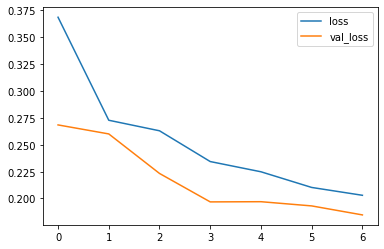

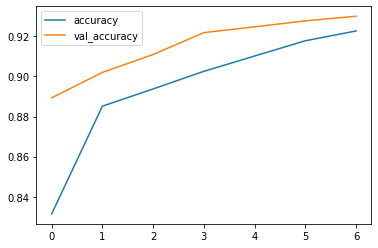

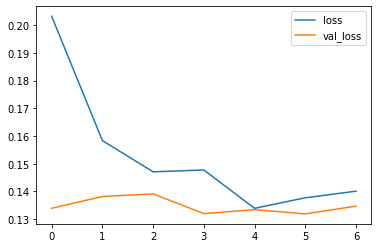

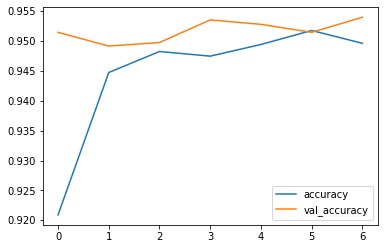

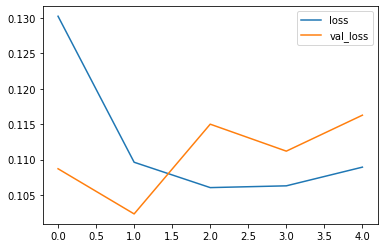

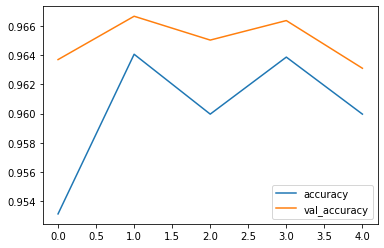

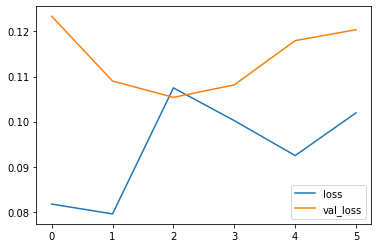

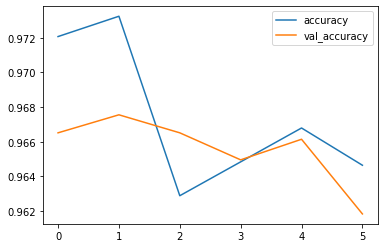

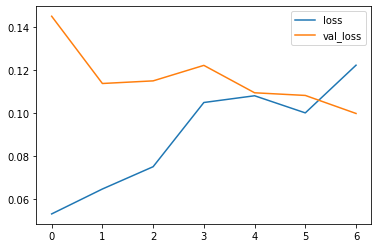

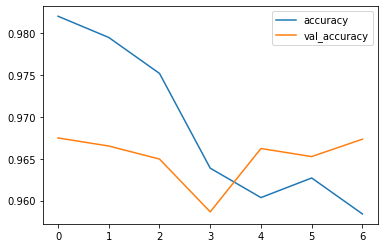

In [18]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

y_prediction = []
scores = []

for fold, (train_index, val_index) in enumerate(skf.split(train['text'], y)):
    print('*'*14, f" Fold {fold} ", '*'*14, '\n')

    # Splitting Data
    X_train, X_valid = train['text'][train_index], train['text'][val_index]
    y_train, y_valid = y[train_index], y[val_index]

    # Encode Data
    X_train = bert_encode(X_train.astype(str), tokenizer)
    X_valid = bert_encode(X_valid.astype(str), tokenizer)

    y_train = y_train.values
    y_valid = y_valid.values

    # Define train & valid dataset
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((X_train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )

    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((X_valid, y_valid))
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(AUTO)
    )
    
    # Define Model
    model = build_model(transformer_layer, max_len=MAX_LEN)

    # Training
    history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        steps_per_epoch=320,
        #batch_size=512,
        epochs=7,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    # Save Model Weights
    model.save_weights(f"sst_keras_model_fold{fold}.h5")
    
    # Make X_val prediction
    y_pred = model.predict(X_valid)
    
    # Evaluate Model
    mse = mean_squared_error(y_valid, y_pred)
    scores.append(mse)
    print("\n MSE :", mse, '\n')
    
    # Test prediction
    y_prediction.append(model.predict(test_text, verbose=0) )
    plot_curve(history)
        
    print("\n")

    # Free the memory
    del X_train, X_valid, y_train, y_valid, train_dataset, valid_dataset, history, y_pred, mse
    gc.collect()

In [19]:
print("Mean Squared Error : ", np.array(scores).mean(axis=0) )

Mean Squared Error :  0.03394717733290073


In [20]:
preds = np.array(y_prediction).mean(axis=0)
len(preds), test.shape[0]

(872, 872)

# Submission

In [21]:
sub = pd.read_csv('../input/stanford-sentiment-treebank/sample_submission.csv')
sub['target'] = preds

sub.to_csv("submission.csv", index=False)
sub.describe().T

,count,mean,std,min,25%,50%,75%,max
id,872.0,435.500000,251.869014,0.000000,217.750000,435.500000,653.250000,871.000000
target,872.0,0.545481,0.448896,0.000934,0.029499,0.707057,0.998064,0.999915


In [22]:
sub

,id,target
0,787,0.091189
1,458,0.996254
2,423,0.133016
3,466,0.972613
4,545,0.030424
...,...,...
867,546,0.203024
868,574,0.012985
869,443,0.999697
870,6,0.010844
